In [1]:
import awkward as ak
import numpy as np
import pandas as pd
import numba
import glob
from tqdm import tqdm
print(ak.__version__)

debug = True

sample = "VBF"
#options MinBias, VBF, GG
if sample == "MinBias":
    filepath = "Phase2-L1MenuTools/cache/V37nano/V37nano_MinBias*"
elif sample == "GG":
    filepath = "Phase2-L1MenuTools/cache/V37nano/V37nano_GluGLuToHHToB2Tau*"
elif sample == "VBF":
    filepath = "Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau*"


debug = True

files = glob.glob(filepath)
print(files)
#Get the files:
#Get the files:
arrays = [ak.from_parquet(file) for file in files]
# Get the objectnames:
import re
regex = re.compile(r'^{}|{}$'.format(re.escape(filepath[:-1]+"_"), re.escape(".parquet")))


objectnames = [regex.sub("",file) for file in files]
print(objectnames)

2.6.4
['Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenJet.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenJetAK8.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenMET.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenPart.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenVisTau.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1EGbarrel.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1EGendcap.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1TrackHT.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1TrackJet.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1TrackMET.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1caloJet.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1caloTau.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1gmtMuon.parquet', 'Phase2-L1MenuTools/ca

In [2]:
#Store objects in a dict
objectsdict = dict()
for idx,item in enumerate(objectnames): 
    objectsdict[item] = arrays[idx]

In [3]:
#helper functions:
import vector
vector.register_awkward()


def prepare_objects(dictobj):
    fourvectordict = dict()
    standardizeddict = dict()
    vector.register_awkward()

    for key,value in dictobj.items():
        standardizeddict[key] = value
        fields = value.fields
        for field in fields:
            standardname = field.replace(key+"_","")
            standardizeddict[key][standardname] = dictobj[key][field]
            standardizeddict[key] = ak.without_field(standardizeddict[key],field)
            dictobj[key] = ak.without_field(value,field)
        print(key,":",standardizeddict[key].fields)
        fourvectordict[key] =  ak.Array(standardizeddict[key],with_name="Momentum3D")
    return fourvectordict,standardizeddict



    # # combining to numpy
def prepare_for_ml(objects,padlist,namelist,pad_val = 0):
    pad_arrs = []
    var_names = []
    for idx,object in enumerate(objects):
        topad = padlist[idx]
        name = namelist[idx]
        
        if topad == 1:
            pad_arr = object
        else:
            pad_arr = ak.pad_none(object,topad,axis=1,clip=True)
        for i in range(topad):
            for var in object.fields:
                if topad == 1:
                    pad_arrs += [ak.to_numpy(pad_arr[var][:])]
                else:
                    pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
                var_names.append( "{}_{}_{}".format(name, i, var) )
    return var_names, pad_arrs 

fourvectordict,standardizeddict = prepare_objects(objectsdict)



GenJet : ['pt', 'eta', 'phi', 'partonFlavour']
GenJetAK8 : ['pt', 'eta', 'phi']
GenMET : ['phi', 'pt']
GenPart : ['pt', 'eta', 'phi', 'pdgId', 'statusFlags']
GenVisTau : ['status', 'charge', 'genPartIdxMother', 'eta', 'mass', 'phi', 'pt']
L1EGbarrel : ['eleId', 'phoId', 'saId', 'hwQual', 'eta', 'phi', 'pt']
L1EGendcap : ['eleId', 'phoId', 'saId', 'hwQual', 'eta', 'phi', 'pt']
L1TrackHT : ['ht', 'mht']
L1TrackJet : ['pt', 'eta', 'phi']
L1TrackMET : ['pt']
L1caloJet : ['et', 'eta', 'phi', 'pt']
L1caloTau : ['eta', 'phi', 'pt']
L1gmtMuon : ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'd0', 'eta', 'phi', 'pt', 'z0']
L1gmtTkMuon : ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'd0', 'eta', 'phi', 'pt', 'z0']
L1hpsTau : ['eta', 'phi', 'pt']
L1nnCaloTau : ['hwIso', 'hwQual', 'eta', 'phi', 'pt']
L1nnPuppiTau : ['charge', 'id', 'passLooseNN', 'passLooseNNMass', 'passLoosePF', 'passMass', 'passTightNN', 'passTightNNMass', 'passT

In [4]:

def DeltaRcalc(obj_a,obj_b):
    #returns the delta in the dimensions of the second object with delta R  first objects, second
    combo = ak.cartesian({"a": obj_a,"b": obj_b}, nested=True ,axis=-1)
    mapped_a,mapped_b = ak.unzip(combo)
    deltaR = mapped_a.deltaR(mapped_b)
    return deltaR





def mapObjects(objects_a, objects_b):
    
    # Create a Cartesian product between  objects
    paired_objects = ak.cartesian({"a": objects_a, "b": objects_b}, nested=True)
    
    # Unzip the pairs into separate arrays 
    mapped_a, mapped_b = ak.unzip(paired_objects)
    
    # Return the mapped  objects
    return mapped_a, mapped_b



def prepare_relative_dR(obj_a, obj_b, vec_a, vec_b, mask):
    """
    Prepares a sorted, flattened array of objects based on their DeltaR values.

    Parameters:
    - obj_a, obj_b: Input objects to be mapped using mapObjects function.
    - vec_a, vec_b: fourvectors used to calculate DeltaR.
    - mask: Boolean mask used for masking objects based on  matching.

    Returns:
    - Flattened array of sorted objects after applying the mask.
    """
    # Map obj_a and obj_b into mapped objects:
    mapped_obj_a, mapped_obj_b = mapObjects(obj_a, obj_b)
    
    # Calculate DeltaR between vec_c and vec_d
    delta_r = DeltaRcalc(vec_a, vec_b)
    
    # Sort the objects based on their DeltaR values
    sorted_indices = ak.argsort(delta_r)
    sorted_objects = mapped_obj_b[sorted_indices]
    
    # Flatten the result
    filtered_objects = ak.flatten(sorted_objects, axis=1)
    
    return filtered_objects


In [5]:
#remove empty fields:
for key, value in standardizeddict.items():
    for field in value.fields:
        if ak.sum(value[field]) == 0:
            print(key,field,"field removed")
            standardizeddict[key] = ak.without_field(standardizeddict[key],field)
#remove physical vals:
removal = ["L1gmtMuon",
"L1gmtTkMuon",
]            
if (sample == "VBF") or (sample == "GG"):
    standardizeddict["L1puppiJetHisto"] = ak.without_field(standardizeddict["L1puppiJetHisto"],'et')
    standardizeddict["L1caloJet"] = ak.without_field(standardizeddict["L1caloJet"],'et')
for i in removal:
    print("before",standardizeddict[i].fields)
    standardizeddict[i] = ak.without_field(standardizeddict[i],'pt')
    standardizeddict[i] = ak.without_field(standardizeddict[i],'eta')
    standardizeddict[i] = ak.without_field(standardizeddict[i],'phi')
    print("after",standardizeddict[i].fields)

L1EGendcap phoId field removed
L1gmtMuon chargeNoPh field removed
L1gmtMuon hwIso field removed
L1gmtMuon d0 field removed
L1gmtMuon z0 field removed
L1gmtTkMuon chargeNoPh field removed
L1gmtTkMuon hwIso field removed
L1gmtTkMuon d0 field removed
L1nnPuppiTau charge field removed
L1nnPuppiTau dXY field removed
L1nnPuppiTau fullIso field removed
L1tkElectron hwEta field removed
L1tkElectron hwIso field removed
L1tkElectron hwPhi field removed
L1tkElectron hwPt field removed
L1tkPhoton hwEta field removed
L1tkPhoton hwIso field removed
L1tkPhoton hwPhi field removed
L1tkPhoton hwPt field removed
before ['charge', 'hwBeta', 'hwEta', 'hwPhi', 'hwPt', 'hwQual', 'eta', 'phi', 'pt']
after ['charge', 'hwBeta', 'hwEta', 'hwPhi', 'hwPt', 'hwQual']
before ['charge', 'hwBeta', 'hwEta', 'hwPhi', 'hwPt', 'hwQual', 'eta', 'phi', 'pt', 'z0']
after ['charge', 'hwBeta', 'hwEta', 'hwPhi', 'hwPt', 'hwQual', 'z0']


In [6]:
mask = ak.ones_like(standardizeddict["L1caloTau"].pt, dtype=bool)# Prepare objects:
muons = prepare_relative_dR(standardizeddict["L1caloTau"], standardizeddict["L1gmtMuon"],  fourvectordict["L1caloTau"], fourvectordict["L1gmtMuon"],mask)
tkmuons = prepare_relative_dR(standardizeddict["L1caloTau"], standardizeddict["L1gmtTkMuon"],  fourvectordict["L1caloTau"], fourvectordict["L1gmtTkMuon"],mask)
photons = prepare_relative_dR(standardizeddict["L1caloTau"], standardizeddict["L1tkPhoton"],  fourvectordict["L1caloTau"], fourvectordict["L1tkPhoton"],mask)
electrons = prepare_relative_dR(standardizeddict["L1caloTau"], standardizeddict["L1tkElectron"],  fourvectordict["L1caloTau"], fourvectordict["L1tkElectron"],mask)
jets = prepare_relative_dR(standardizeddict["L1caloTau"], standardizeddict["L1puppiJetHisto"],  fourvectordict["L1caloTau"], fourvectordict["L1puppiJetHisto"],mask)
calojets = prepare_relative_dR(standardizeddict["L1caloTau"], standardizeddict["L1caloJet"],  fourvectordict["L1caloTau"], fourvectordict["L1caloJet"],mask)

# Prepare the objects for ML input
objects_to_map = [muons, electrons, photons, jets, tkmuons, calojets]
fields = (
    muons.fields
    + electrons.fields
    + photons.fields
    + jets.fields
    + tkmuons.fields
    + calojets.fields
)
object_names = [
    "L1gmtMuon",
    "L1tkElectron",
    "L1tkPhoton",
    "L1puppiJetHisto",
    "L1gmtTkMuon",
    "L1caloJet"
]
pad_lengths = [2, 5, 5, 5, 3, 4]

# Prepare data:
dr_names, dr_temp_values = prepare_for_ml(objects_to_map, pad_lengths, object_names)
dr_values = np.vstack(dr_temp_values)
dr_values = np.swapaxes(dr_values, 0, 1)

In [7]:
tausnames = ["calotaus_" + i for i in standardizeddict["L1caloTau"].fields]

names =tausnames + dr_names
print(len(names))
print(names)

153
['calotaus_eta', 'calotaus_phi', 'calotaus_pt', 'L1gmtMuon_0_charge', 'L1gmtMuon_0_hwBeta', 'L1gmtMuon_0_hwEta', 'L1gmtMuon_0_hwPhi', 'L1gmtMuon_0_hwPt', 'L1gmtMuon_0_hwQual', 'L1gmtMuon_1_charge', 'L1gmtMuon_1_hwBeta', 'L1gmtMuon_1_hwEta', 'L1gmtMuon_1_hwPhi', 'L1gmtMuon_1_hwPt', 'L1gmtMuon_1_hwQual', 'L1tkElectron_0_eleId', 'L1tkElectron_0_phoId', 'L1tkElectron_0_saId', 'L1tkElectron_0_hwQual', 'L1tkElectron_0_charge', 'L1tkElectron_0_eta', 'L1tkElectron_0_phi', 'L1tkElectron_0_pt', 'L1tkElectron_0_relIso', 'L1tkElectron_0_z0', 'L1tkElectron_1_eleId', 'L1tkElectron_1_phoId', 'L1tkElectron_1_saId', 'L1tkElectron_1_hwQual', 'L1tkElectron_1_charge', 'L1tkElectron_1_eta', 'L1tkElectron_1_phi', 'L1tkElectron_1_pt', 'L1tkElectron_1_relIso', 'L1tkElectron_1_z0', 'L1tkElectron_2_eleId', 'L1tkElectron_2_phoId', 'L1tkElectron_2_saId', 'L1tkElectron_2_hwQual', 'L1tkElectron_2_charge', 'L1tkElectron_2_eta', 'L1tkElectron_2_phi', 'L1tkElectron_2_pt', 'L1tkElectron_2_relIso', 'L1tkElectron_2_z

In [8]:
#prepare data:
from numpy.lib.recfunctions import structured_to_unstructured

# Flatten:
flattened_taus = ak.flatten(standardizeddict["L1caloTau"])
numpy_taus = ak.to_numpy(flattened_taus)

# Convert:
unstructured_taus = structured_to_unstructured(numpy_taus)

# Concatenate:`
values = np.concatenate((unstructured_taus, dr_values), axis=1)

In [9]:
from pickle import load
from sklearn.preprocessing import StandardScaler
inpath = "logs/20240907-171419model_post_fit.keras"
scaler = load(open("smallnet_outputs_for_training_2024_09_07-03_06_22_PM/scaler.pkl", 'rb'))
x_scaled = scaler.transform(values)


In [10]:
import os
from datetime import datetime
datenow = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
outdir = "minbias_outputs_for_rate_{}/".format(datenow)
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [11]:

from keras.models import load_model
loaded_model = load_model("logs/20240907-171419model_post_fit.keras")
predictions = loaded_model.predict((x_scaled))

2024-09-08 10:50:56.415357: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 10:50:56.480617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 10:51:03.909112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 10:51:03.926877: I tens

10623/10623 [==============================] - 17s 2ms/step


In [12]:
mappedtauscores = ak.unflatten(predictions,ak.num(standardizeddict["L1caloTau"]))
flattened_mappedtauscores = ak.flatten(mappedtauscores, axis=-1)

# Add a new field 'gtscore' to 'standardizeddict["L1caloTau"]' with the'flattened_mappedtauscores' values
output_data = ak.with_field(standardizeddict["L1caloTau"], flattened_mappedtauscores, "gtscore")

# Save the output data to a Parquet file
output_file_path = filepath[:-1]+"_L1nnGTTau.parquet"
ak.to_parquet(output_data, output_file_path)



  created_by: parquet-cpp-arrow version 16.0.0
  num_columns: 4
  num_rows: 99701
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [14]:

xyz = ak.flatten(mappedtauscores,axis=-1)
outp = ak.with_field(standardizeddict["L1caloTau"],xyz,"gtscore")
yx = ak.unflatten(y,ak.num(standardizeddict["L1caloTau"]))
print(outdir)
yxx = ak.max(yx,axis= -1)
xxx = ak.max(xx,axis=-1)

xxx2 = ak.min(xx,axis=-1)


NameError: name 'y' is not defined

In [ ]:
print(yxx)

print(xxx)

In [15]:
mask = (ak.mask(outp.gtscore,outp.gtscore > 0.15))
count = ak.num(mask,axis=-1)
mask = ak.drop_none(mask)
count = ak.num(mask,axis=-1)
# masked_gtscore = [outp.gtscore > 0.15]
# masked_gtscore_flat = ak.flatten(masked_gtscore,axis=-1)
# gtcounts = ak.num(masked_gtscore)


Text(0, 0.5, 'Frequency')

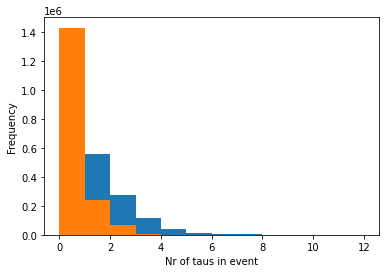

In [17]:
calotaus_mask = ak.num(standardizeddict["L1caloTau"],axis=-1)
import matplotlib.pyplot as plt
ak.max(calotaus_mask)
plt.hist(calotaus_mask, bins=12)  # Adjust the number of bins as needed
plt.hist(count,bins=ak.max(count))

plt.xlabel('Nr of taus in event')
plt.ylabel('Frequency')

In [18]:
print(len(calotaus_mask))
print(len(count))

1747709
1747709


In [19]:
ak.max(count)

6

In [20]:
ak.max(count)

NameError: name 'coutn' is not defined

Text(0, 0.5, 'Occurrences')

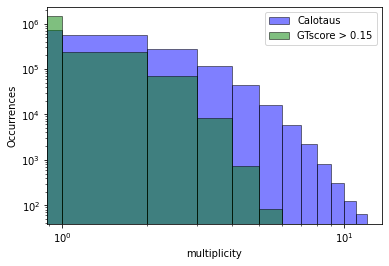

In [21]:
plt.hist(calotaus_mask, bins=12, alpha=0.5, label='Calotaus', color='blue', edgecolor='black')
plt.hist(count, bins=ak.max(count), alpha=0.5, label='GTscore > 0.15', color='green', edgecolor='black')

# Adding labels and title
plt.legend()
plt.loglog()
plt.xlabel('multiplicity')
plt.ylabel('Occurrences')
# plt.title('')

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (13).

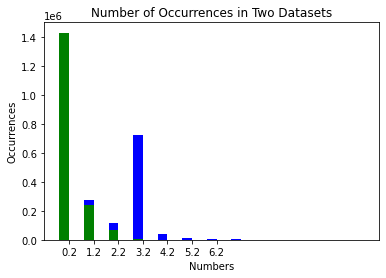

In [22]:
from collections import Counter
occurrences1 = Counter(calotaus_mask)
occurrences2 = Counter(count)

# Extract the keys (unique numbers) and values (counts) for both datasets
x1 = list(occurrences1.keys())
y1 = list(occurrences1.values())

x2 = list(occurrences2.keys())
y2 = list(occurrences2.values())

# Plotting the first dataset
bar_width = 0.4  # Width of the bars
index = np.arange(len(x1))

plt.bar(index, y1, bar_width, label='Calotaus', color='blue')
index = np.arange(len(x2))

# Plotting the second dataset, with an offset for clarity
plt.bar(index, y2, bar_width, label='GTscore > 0.15', color='green')

# Adding labels and title
plt.xlabel('Numbers')
plt.ylabel('Occurrences')
plt.title('Number of Occurrences in Two Datasets')

# Adjusting the x-ticks to show the correct labels
plt.xticks(index + bar_width / 2, x1)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

NameError: name 'home' is not defined

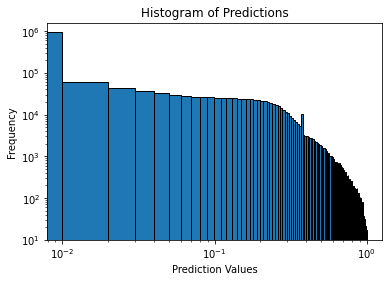

In [23]:
import matplotlib.pyplot as plt
plt.hist(predictions, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Predictions')
plt.loglog()
plt.xlabel('Prediction Values')
plt.ylabel('Frequency')


In [24]:
xxxpad = ak.pad_none(xxx,1,axis=-1)
xxxfill = ak.fill_none(xxxpad,0,axis=-1)
yxxfill = ak.fill_none(yxx,1)
print(xxxfill)
print(0)


xxxpad2 = ak.pad_none(xxx2,1,axis=-1)
xxxfill2 = ak.fill_none(xxxpad2,0,axis=-1)
# yxxfill2 = ak.fill_none(yxx2,1)
print(xxxfill2)
# y_flat = ak.flatten(yxxfill,axis = None)
x_flat2 = ak.flatten(xxxfill2,axis = None)
# y_test = np.zeros(len(x_flat))
print(0)

NameError: name 'xxx' is not defined

In [ ]:
len(standardizeddict["L1caloTau"])
len(xxxfill)
def totalMinBiasRate(nCollBunch = 2500):
    LHCfreq = 11245.6
    return LHCfreq * nCollBunch / 1e3

In [ ]:
print(xxxfill)

In [ ]:
y_flat = ak.flatten(yxxfill,axis = None)
x_flat = ak.flatten(xxxfill,axis = None)
y_test = np.zeros(len(x_flat))

In [ ]:

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr2, tpr2, thr2 = roc_curve( y_test, x_flat, drop_intermediate=False)
fpr, tpr, thr = roc_curve( y_test, x_flat2, drop_intermediate=False)

# plt.plot(fpr2 * totalMinBiasRate() ,thr2 * -1)

plt.plot(fpr2 * totalMinBiasRate(), thr2 , label ="max")

plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("NN threshhold (1 -x)")
plt.xscale("log")
plt.grid()
plt.xlim(0,1000)
plt.show()
plt.plot(fpr * totalMinBiasRate(), thr , label ="min")

plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("NN threshhold (1 -x)")
plt.xscale("log")
plt.grid()
plt.xlim(0,1000)


In [ ]:
, drop_intermediate=False)

plt.plot(fpr1, tpr1)
